<h1 align="center">Supervised ML</h1>

---

<center><h2>Lesson 04</h2></center>


## **Intro to Supervised Machine Learning**

- Understand what supervised learning is and identify its core components: features (inputs), labels (targets), and training data.
- Distinguish between classification and regression problems using concrete examples.
- Build intuition for decision trees as rule-based models that split data based on feature thresholds.
- Train and inspect a simple decision tree using scikit-learn.
- Perform train/validation/test splits and interpret basic evaluation results (accuracy, confusion matrix).

![Machine Learning Types](../../files/machine_learning_types.png)


### What is Supervised Learning?

Supervised learning pairs labeled examples with an algorithm that learns how to map inputs to outputs. Once trained, the model can make predictions on new, unseen data.

**Key pieces**

- **Dataset**: collection of examples we care about.
- **Features (`x`)**: measurable inputs like heart rate, pixels, or number of people on each track.
- **Labels (`y`)**: correct answers provided by humans, instruments, or previous experiments.
- **Model**: algorithm (decision tree, neural net, etc.) that learns a mapping from features to labels.
- **Training**: process of adjusting the model based on data so predictions get closer to true labels.
- **Evaluation**: how we score the model’s predictions (e.g., accuracy, mean squared error) to decide if it is good enough or needs improvement.

**Classification vs. regression**

- Classification predicts categories (e.g., "tumor is benign or malignant").
- Regression predicts continuous numbers (e.g., blood glucose level in mg/dL).

**The feedback loop**
Data → Model → Predictions → Compare to Labels → Learn → Repeat


## The Titanic Dataset

![Titanic Depiction](../../files/titanic.jpg)

**https://www.kaggle.com/datasets/yasserh/titanic-dataset**


We’ll use the classic **Titanic survival** dataset as a supervised learning problem.

We can frame it as supervised learning:

- **Inputs/features**: passenger info like class (`pclass`), sex, age, fare, and port of embarkation.
- **Output/label**: whether the passenger **survived** (`1`) or **did not survive** (`0`).
- This dataset is historical and widely used for teaching ML workflows (it is not a “fairness benchmark”).


### Dataset Preview

We’ll load the dataset into a DataFrame and inspect a few rows to understand the columns and missing values.


In the Titanic dataset, we’ll use a small set of human-readable features to predict survival:

- `pclass`: passenger class (1st, 2nd, 3rd).
- `sex`: passenger sex.
- `age`: passenger age (years; may have missing values).
- `sibsp`: number of siblings/spouses aboard.
- `parch`: number of parents/children aboard.
- `fare`: ticket price.
- `embarked`: port of embarkation (C/Q/S).

The label we want to predict is:

- `survived`: `1` if the passenger survived, `0` otherwise.


### ✏️ Exercise: Copy the prompt below into copilot chat to load the Titanic Dataset

#### **Prompt:**

Load the titanic dataset as a dataframe using fetch_openml

In [1]:
import pandas as pd
from sklearn.datasets import fetch_openml

# Load the Titanic dataset from OpenML
titanic = fetch_openml(name="titanic", version=1, as_frame=True)

# Extract features as a pandas DataFrame
df = titanic.frame

# Display basic info to verify load
print(df.shape)
df.head()


(1309, 14)


,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1,1,"Allen, Miss. Elisabeth Walton",female,29.0000,0,0,24160,211.3375,B5,S,2,NaN,"St Louis, MO"
1,1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.5500,C22 C26,S,11,NaN,"Montreal, PQ / Chesterville, ON"
2,1,0,"Allison, Miss. Helen Loraine",female,2.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30.0000,1,2,113781,151.5500,C22 C26,S,NaN,135.0,"Montreal, PQ / Chesterville, ON"
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"


### ✏️ Exercise: Visualize the Titanic Dataset

#### **Prompt:**

Create a clean, well-organized Plotly figure with multiple subplots to visualize key metrics from the Titanic dataset. Use a single figure with clearly labeled subplots showing: (1) survival counts, (2) survival rate by sex, (3) survival rate by passenger class, and (4) age distribution split by survival status. Ensure consistent styling across subplots, readable axis labels and titles, and an overall layout suitable for teaching (minimal clutter, clear legends, and appropriate spacing).


In [2]:
import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# --- Basic cleaning / standardization (safe for OpenML Titanic) ---
df_viz = df.copy()

# Standardize key columns (OpenML Titanic commonly uses these names)
# survived is often {"0","1"} as strings; normalize to int where possible
df_viz["survived"] = pd.to_numeric(df_viz.get("survived"), errors="coerce")
df_viz["age"] = pd.to_numeric(df_viz.get("age"), errors="coerce")

# Normalize sex labels
df_viz["sex"] = df_viz.get("sex").astype(str).str.lower().str.strip()

# pclass can be string/object; normalize to int where possible
df_viz["pclass"] = pd.to_numeric(df_viz.get("pclass"), errors="coerce")

# Drop rows missing survived for rate calculations
df_labeled = df_viz[df_viz["survived"].notna()].copy()
df_labeled["survived"] = df_labeled["survived"].astype(int)

# Helper for survival rates
def survival_rate_by(group_col: str) -> pd.Series:
    tmp = df_labeled[[group_col, "survived"]].dropna()
    if tmp.empty:
        return pd.Series(dtype=float)
    return tmp.groupby(group_col)["survived"].mean().sort_index()

# --- (1) Survival counts ---
surv_counts = df_labeled["survived"].value_counts().sort_index()
count_x = ["Died (0)", "Survived (1)"]
count_y = [int(surv_counts.get(0, 0)), int(surv_counts.get(1, 0))]

# --- (2) Survival rate by sex ---
sex_rates = survival_rate_by("sex")
sex_x = sex_rates.index.tolist()
sex_y = (sex_rates.values * 100).tolist()

# --- (3) Survival rate by passenger class ---
class_rates = survival_rate_by("pclass")
class_x = [f"Class {int(c)}" if pd.notna(c) else str(c) for c in class_rates.index.tolist()]
class_y = (class_rates.values * 100).tolist()

# --- (4) Age distribution split by survival status ---
ages_survived = df_labeled.loc[(df_labeled["survived"] == 1) & (df_labeled["age"].notna()), "age"]
ages_died = df_labeled.loc[(df_labeled["survived"] == 0) & (df_labeled["age"].notna()), "age"]

# --- Build a single figure with subplots ---
fig = make_subplots(
    rows=2, cols=2,
    subplot_titles=(
        "Survival Counts",
        "Survival Rate by Sex",
        "Survival Rate by Passenger Class",
        "Age Distribution by Survival Status",
    ),
    horizontal_spacing=0.10,
    vertical_spacing=0.14
)

# (1) Survival counts (bar)
fig.add_trace(
    go.Bar(x=count_x, y=count_y, name="Count", showlegend=False),
    row=1, col=1
)

# (2) Survival rate by sex (bar)
fig.add_trace(
    go.Bar(x=sex_x, y=sex_y, name="Survival rate (%)", showlegend=False),
    row=1, col=2
)

# (3) Survival rate by pclass (bar)
fig.add_trace(
    go.Bar(x=class_x, y=class_y, name="Survival rate (%)", showlegend=False),
    row=2, col=1
)

# (4) Age distribution by survival (histograms with shared bins)
fig.add_trace(
    go.Histogram(x=ages_died, name="Died (0)", opacity=0.75, nbinsx=30),
    row=2, col=2
)
fig.add_trace(
    go.Histogram(x=ages_survived, name="Survived (1)", opacity=0.75, nbinsx=30),
    row=2, col=2
)

# --- Axes labels / formatting ---
fig.update_yaxes(title_text="Passengers", row=1, col=1)
fig.update_yaxes(title_text="Survival rate (%)", range=[0, 100], row=1, col=2)
fig.update_yaxes(title_text="Survival rate (%)", range=[0, 100], row=2, col=1)
fig.update_xaxes(title_text="Survival outcome", row=1, col=1)
fig.update_xaxes(title_text="Sex", row=1, col=2)
fig.update_xaxes(title_text="Passenger class", row=2, col=1)
fig.update_xaxes(title_text="Age (years)", row=2, col=2)
fig.update_yaxes(title_text="Count", row=2, col=2)

# --- Overall layout (teaching-friendly) ---
fig.update_layout(
    title="Titanic Dataset: Quick EDA Snapshot",
    height=750,
    width=1000,
    template="plotly_white",
    barmode="overlay",
    legend_title_text="",
    legend=dict(
        orientation="h",
        yanchor="bottom",
        y=-0.12,
        xanchor="center",
        x=0.5
    ),
    margin=dict(l=60, r=30, t=80, b=90)
)

fig.show()


Decision trees break decisions into small yes/no questions until they reach a conclusion. A tiny (illustrative) tree for Titanic might look like:

```
Start
├─ Is sex == female? → Yes → Predict Survived
└─ No
   ├─ Is pclass == 1? → Yes → Predict Survived
   └─ No → Predict Did Not Survive
```

Each question corresponds to a split on one feature, and the final prediction is a **leaf node**.

**Check-your-understanding**

1. Which feature do you think a tree should split on first for Titanic? Why?
2. What does a “leaf” represent in a decision tree?


# Decision Trees

A **decision tree** is a supervised machine learning model that makes predictions by asking a sequence of simple **if/then** questions about the input features.

## How it works

- The tree starts at the **root** (the first question).
- Each question applies a **split rule** (e.g., `age < 15`, `sex == "female"`).
- Splits create **branches** that route examples into smaller groups.
- The process continues until reaching a **leaf**, which outputs the final prediction:
  - **Classification**: a class label (e.g., survived vs. not survived)
  - **Regression**: a numeric value

## Why people like decision trees

- **Interpretable**: you can explain a prediction by tracing the path of decisions taken.
- **Flexible features**: works with both **numeric** and **categorical** inputs.
- **Handles nonlinearity**: can capture nonlinear patterns without feature scaling.


![Decision Tree](../../files/decision_tree.png)


### ✏️ Exercise: Build a Simple Classifier by Hand

Before we train a real model, we’ll build a tiny **rule-based baseline**. This mimics the idea of a decision tree split without doing any optimization.

**Rules (use these exactly in your code):**

1. If `sex == "female"`, predict `survived = 1`.
2. Else if `age < 15`, predict `survived = 1`.
3. Otherwise, predict `survived = 0`.

We’ll then compute the accuracy of this heuristic on the dataset.


#### **Prompt:**

Implement and evaluate a simple heuristic baseline for Titanic survival using a dataframe called df. Assume df includes the columns survived, sex, age, and pclass, even if the values are missing or inconsistently formatted. Define a function predict_survival(row) that predicts survival by returning 1 if the passenger is female (case-insensitive), otherwise returning 1 if the passenger’s age can be parsed as a number and is under 15, and returning 0 in all other cases. Convert both age and survived to numeric using pd.to_numeric(..., errors="coerce"), add the predictions to the dataframe as a new column called rule_pred using df.apply(..., axis=1), and compute accuracy only for rows where survived is not missing. Finally, print the accuracy with a clear label and display the first 10 rows showing survived, sex, age, pclass, and rule_pred.


In [3]:
import pandas as pd

def predict_survival(row):
    # sex: case-insensitive string compare
    sex = str(row.get("sex", "")).lower().strip()
    # age: robust numeric parse
    age = pd.to_numeric(row.get("age", pd.NA), errors="coerce")

    if sex == "female":
        return 1
    if pd.notna(age) and float(age) < 15:
        return 1
    return 0

# Ensure the label is numeric 0/1 where possible
df["survived"] = pd.to_numeric(df["survived"], errors="coerce")
df["age"] = pd.to_numeric(df["age"], errors="coerce")

# Apply the heuristic rule
df["rule_pred"] = df.apply(predict_survival, axis=1)

# Compute accuracy only on rows with non-missing label
y_true = pd.to_numeric(df["survived"], errors="coerce")
mask = y_true.notna()

rule_accuracy = (df.loc[mask, "rule_pred"] == y_true.loc[mask].astype(int)).mean()

print(f"Heuristic baseline accuracy (rows with non-missing label): {rule_accuracy:.2f}")

df[["survived", "sex", "age", "pclass", "rule_pred"]].head(10)


Heuristic baseline accuracy (rows with non-missing label): 0.78


,survived,sex,age,pclass,rule_pred
0,1,female,29.0000,1,1
1,1,male,0.9167,1,1
2,0,female,2.0000,1,1
3,0,male,30.0000,1,0
4,0,female,25.0000,1,1
5,1,male,48.0000,1,0
6,1,female,63.0000,1,1
7,0,male,39.0000,1,0
8,1,female,53.0000,1,1
9,0,male,71.0000,1,0


This tiny heuristic is a baseline, but it will miss many patterns and interactions in the data. Rather than hand-coding every rule, we let ML algorithms search through many possible splits and automatically build trees with a consistent strategy.


### Create a Decision Tree Classifier

`scikit-learn` is a widely used Python library that standardizes ML workflows. The pattern is predictable:

1. Import the model class.
2. Create a model instance (optionally set hyperparameters).
3. Fit on training data (learn patterns).
4. Predict on data.
5. Evaluate with a metric such as accuracy.


### ✏️ Exercise: Prepare the Titanic Dataset for Decision Tree Modeling

#### **Prompt:**

Prepare the Titanic dataset for a Decision Tree model using pandas and scikit-learn, assuming a dataframe df already exists. Use the features pclass, sex, age, sibsp, parch, fare, and embarked, with survived as the label. Create a clean modeling dataframe containing only these columns, convert all numeric fields and the label to numeric values using pd.to_numeric(..., errors="coerce"), and apply simple, transparent imputation by filling missing numeric values with the median and missing categorical values with the mode (or "unknown" if no mode exists), ensuring categorical strings are lowercased. Drop any rows with missing labels, one-hot encode the categorical variables so they can be used by a decision tree, and then construct the feature matrix X and label vector y. Finally, print the shape of X, display the distribution of the labels, and show the first few rows of X, keeping the code clean and readable for instructional use.


In [5]:
import pandas as pd

# -----------------------------
# 1. Select modeling columns
# -----------------------------
feature_cols = ["pclass", "sex", "age", "sibsp", "parch", "fare", "embarked"]
label_col = "survived"

df_model = df[feature_cols + [label_col]].copy()

# -----------------------------
# 2. Convert numeric columns
# -----------------------------
numeric_cols = ["pclass", "age", "sibsp", "parch", "fare", label_col]
for col in numeric_cols:
    df_model[col] = pd.to_numeric(df_model[col], errors="coerce")

# -----------------------------
# 3. Clean categorical columns
# -----------------------------
cat_cols = ["sex", "embarked"]
for col in cat_cols:
    df_model[col] = (
        df_model[col]
        .astype(str)
        .str.lower()
        .str.strip()
        .replace("nan", pd.NA)
    )

# -----------------------------
# 4. Drop rows with missing labels
# -----------------------------
df_model = df_model[df_model[label_col].notna()].copy()
df_model[label_col] = df_model[label_col].astype(int)

# -----------------------------
# 5. Impute missing values
# -----------------------------
# Numeric: median
for col in ["pclass", "age", "sibsp", "parch", "fare"]:
    median_val = df_model[col].median()
    df_model[col] = df_model[col].fillna(median_val)

# Categorical: mode (or "unknown" if no mode)
for col in cat_cols:
    if df_model[col].dropna().empty:
        fill_val = "unknown"
    else:
        fill_val = df_model[col].mode().iloc[0]
    df_model[col] = df_model[col].fillna(fill_val)

# -----------------------------
# 6. One-hot encode categoricals
# -----------------------------
X = pd.get_dummies(
    df_model[feature_cols],
    columns=cat_cols,
    drop_first=True
)

y = df_model[label_col]

# -----------------------------
# 7. Sanity checks / inspection
# -----------------------------
print("Feature matrix shape:", X.shape)
print("\nLabel distribution:")
print(y.value_counts().sort_index())

X.head()


Feature matrix shape: (1309, 8)

Label distribution:
survived
0    809
1    500
Name: count, dtype: int64


,pclass,age,sibsp,parch,fare,sex_male,embarked_q,embarked_s
0,1,29.0000,0,0,211.3375,False,False,True
1,1,0.9167,1,2,151.5500,True,False,True
2,1,2.0000,1,2,151.5500,False,False,True
3,1,30.0000,1,2,151.5500,True,False,True
4,1,25.0000,1,2,151.5500,False,False,True


### ✏️ Exercise: Train and Visualize a Simple Decision Tree on the Titanic Dataset

#### **Prompt:**

Train and visualize a very simple decision tree classifier on the full Titanic dataset to illustrate how decision trees make predictions. Assume a feature matrix `X` and label vector `y` already exist. Fit a `DecisionTreeClassifier` with a fixed `random_state` and a maximum depth of 1, train it on the full dataset, and compute the accuracy on the same data using `accuracy_score`. Print the accuracy with a clear, readable message. Then visualize the trained tree using scikit-learn’s tree plotting utilities, including feature names from `X` and class names labeled as “died (0)” and “survived (1)”. Use filled and rounded nodes, a readable font size, and an appropriate figure size, and add a descriptive title so the visualization is suitable for teaching and discussion.

Decision Tree (max_depth=3) training accuracy (evaluated on full dataset): 0.82


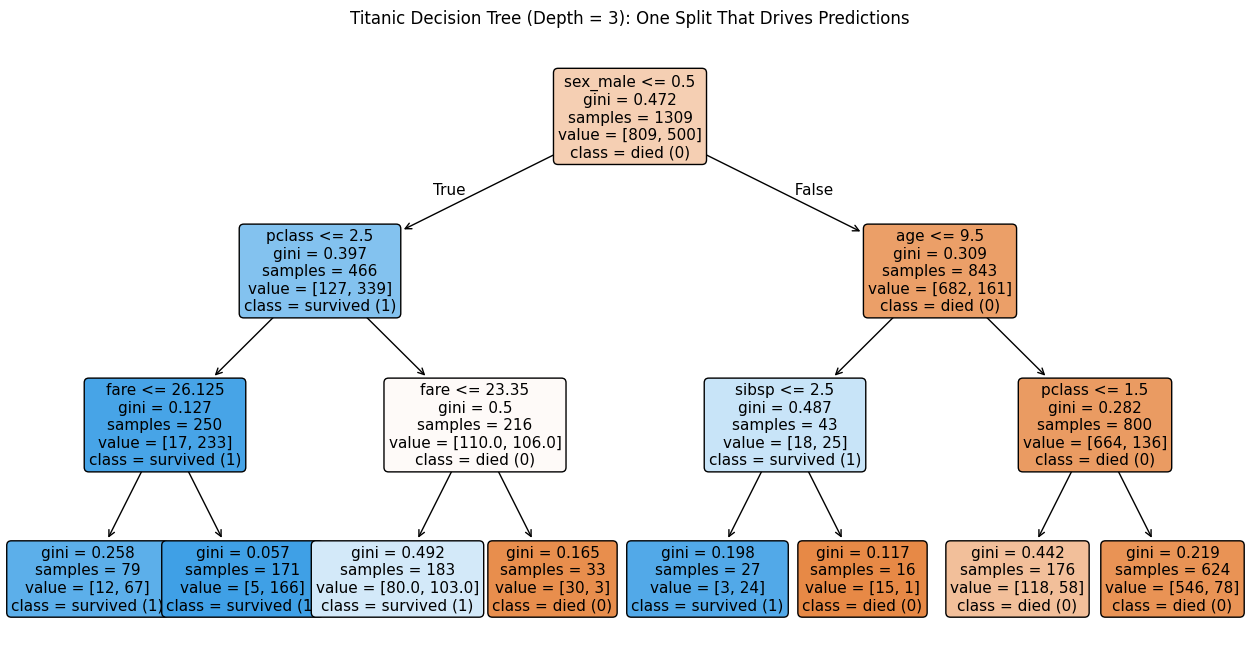

In [8]:
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score


depth=3
# 1) Train a very small decision tree (a "decision stump")
clf = DecisionTreeClassifier(max_depth=depth, random_state=42)
clf.fit(X, y)

# 2) Evaluate on the same data (for illustration only)
y_pred = clf.predict(X)
acc = accuracy_score(y, y_pred)
print(f"Decision Tree (max_depth={depth}) training accuracy (evaluated on full dataset): {acc:.2f}")
 
# 3) Visualize the tree
plt.figure(figsize=(16, 8))
plot_tree(
    clf,
    feature_names=list(X.columns),
    class_names=["died (0)", "survived (1)"],
    filled=True,
    rounded=True,
    fontsize=11
)
plt.title(f"Titanic Decision Tree (Depth = {depth}): One Split That Drives Predictions", pad=12)
plt.show()



### Interpreting Gini and the Diagram

- **Gini impurity** measures how mixed the labels are in a node: $G = 1 - \sum_k p_k^2$, where $p_k$ is the fraction of samples from class $k$. A pure node (all `0` or all `1`) has $G = 0$.
- Each box shows: the split rule, the impurity (`gini`), how many samples reach that node (`samples`), the class counts (`value`), and the predicted class (`class`).
- Reading the tree top to bottom mirrors the decision process: start at the root question, follow the branch that matches a passenger’s features, and stop at a leaf to see the final prediction.


**Why not celebrate yet?** Training and evaluating on the same data can hide overfitting. A deep tree can memorize every row (100% accuracy) but fail on new scenarios. To know how a model will generalize, we need to hold out data the model never sees during training.


### Train / Validation / Test Splits

- **Training set**: used to learn the model parameters.
- **Validation set**: used to tune choices like tree depth or learning rate without touching the test set.
- **Test set**: only used once, at the end, to estimate performance on truly unseen data.

A common recipe is 70% train, 15% validation, 15% test (ratios vary). Guard against **data leakage**, which happens when information from the validation or test set sneaks into training—this makes the model look better than it really is.


<p align="center">
  <img src="../../files/train_val_test_split.webp" alt="Train/Validation/Test Split Diagram">
</p>


---
# Golden Rule of Supervised ML:

### **The test data cannot influence the training phase in any way!**
---


### ✏️ Exercise: Train/Validation/Test Split

#### **Prompt:**

Split the prepared feature matrix X and label vector y into training, validation, and test sets using scikit-learn. First, perform a stratified train–test split to reserve 30% of the data for temporary holdout, using a fixed random_state for reproducibility. Then split this temporary set evenly into validation and test sets, again using stratification to preserve class balance. Finally, print the number of rows in the training, validation, and test sets with clear, readable messages suitable for teaching.


In [9]:
from sklearn.model_selection import train_test_split

# -----------------------------
# 1. Train / temporary split
#    (70% train, 30% temp)
# -----------------------------
X_train, X_temp, y_train, y_temp = train_test_split(
    X,
    y,
    test_size=0.30,
    stratify=y,
    random_state=42
)

# -----------------------------
# 2. Validation / test split
#    (15% val, 15% test)
# -----------------------------
X_val, X_test, y_val, y_test = train_test_split(
    X_temp,
    y_temp,
    test_size=0.50,
    stratify=y_temp,
    random_state=42
)

# -----------------------------
# 3. Report split sizes
# -----------------------------
print(f"Training set size:     {X_train.shape[0]} rows")
print(f"Validation set size:   {X_val.shape[0]} rows")
print(f"Test set size:         {X_test.shape[0]} rows")


Training set size:     916 rows
Validation set size:   196 rows
Test set size:         197 rows


### ✏️ Exercise: Train and Evaluate a Decision Tree Model

#### **Prompt:**

Train and evaluate a small decision tree model on the Titanic dataset using predefined training, validation, and test splits. Assume X_train, X_val, X_test, y_train, y_val, and y_test already exist. Create a DecisionTreeClassifier with a fixed random_state and a limited maximum depth (such as 3), fit it on the training data, and compute accuracy on the training, validation, and test sets using accuracy_score. Finally, summarize the results in a small pandas DataFrame with one row per data split and a corresponding accuracy value, keeping the output clear and suitable for instructional purposes.


In [10]:
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

# 1) Train a small decision tree
tree_clf = DecisionTreeClassifier(max_depth=3, random_state=42)
tree_clf.fit(X_train, y_train)

# 2) Evaluate on train / val / test
train_acc = accuracy_score(y_train, tree_clf.predict(X_train))
val_acc   = accuracy_score(y_val,   tree_clf.predict(X_val))
test_acc  = accuracy_score(y_test,  tree_clf.predict(X_test))

# 3) Summarize results in a simple table
results = pd.DataFrame({
    "split": ["train", "validation", "test"],
    "accuracy": [train_acc, val_acc, test_acc]
})

results


,split,accuracy
0,train,0.811135
1,validation,0.846939
2,test,0.812183


### ✏️ Exercise: Visualize Decision Tree Performance and Feature Importance

#### **Prompt:**

Visualize the performance of a trained decision tree classifier on the Titanic dataset using the test split. Assume a fitted model `tree_model` and the test data `X_test` and `y_test` already exist. First, generate predictions on the test set and display a confusion matrix using scikit-learn with clearly labeled classes (“died (0)” and “survived (1)”), a blue color map, integer counts, and a descriptive title. Then compute the model’s feature importances, identify the most influential features (for example, the top 15), and visualize them as a horizontal bar chart with clear axis labels and a readable title. Use matplotlib for all visualizations and keep the figures clean, interpretable, and suitable for instructional use.


<Figure size 600x500 with 0 Axes>

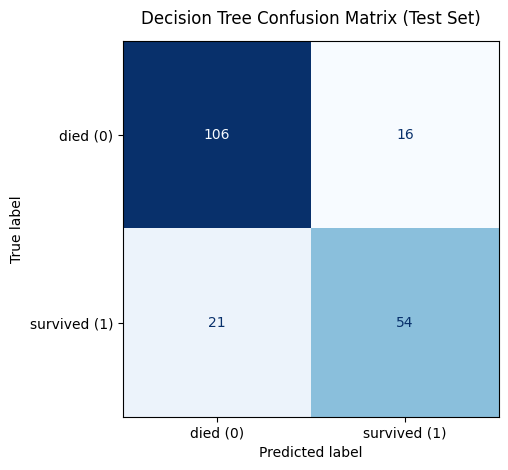

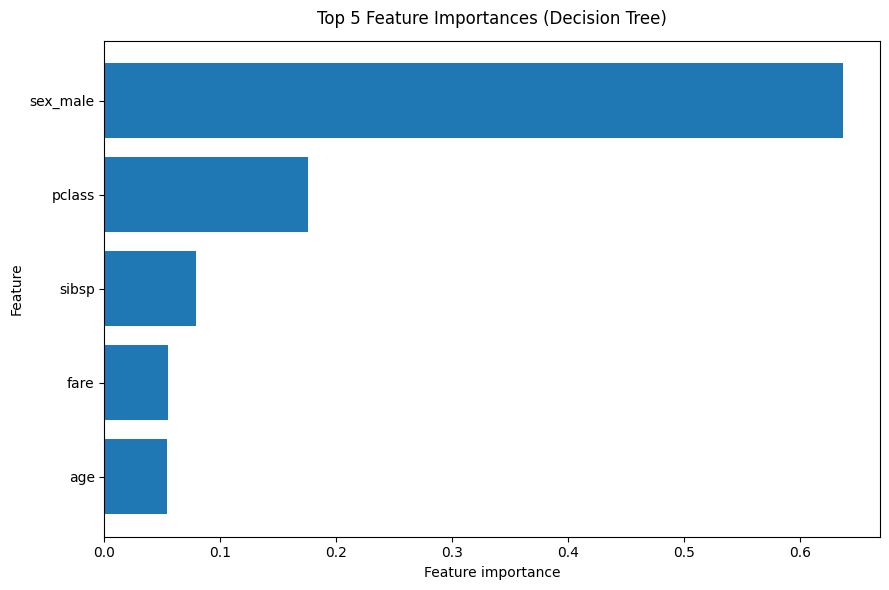

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

# -----------------------------
# 1) Predictions + Confusion Matrix
# -----------------------------
y_pred = tree_clf.predict(X_test)

cm = confusion_matrix(y_test, y_pred, labels=[0, 1])

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=["died (0)", "survived (1)"]
)

plt.figure(figsize=(6, 5))
disp.plot(cmap=plt.cm.Blues, values_format="d", colorbar=False)
plt.title("Decision Tree Confusion Matrix (Test Set)", pad=12)
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.tight_layout()
plt.show()

# -----------------------------
# 2) Feature importances (Top 15)
# -----------------------------
importances = pd.Series(tree_clf.feature_importances_, index=X_test.columns)

# Keep only non-zero importances to reduce clutter (optional but helpful)
importances_nonzero = importances[importances > 0]

top_k = 15
top_importances = importances_nonzero.sort_values(ascending=True).tail(top_k)

plt.figure(figsize=(9, 6))
plt.barh(top_importances.index, top_importances.values)
plt.xlabel("Feature importance")
plt.ylabel("Feature")
plt.title(f"Top {len(top_importances)} Feature Importances (Decision Tree)", pad=12)
plt.tight_layout()
plt.show()


**Reflection prompt:** If your validation accuracy is much higher than test accuracy, what might be happening? How would you investigate it?


### Visualizing the Decision Tree

Decision trees are popular because they are interpretable: you can literally see each split and explain predictions to teammates. Visualizing the trained tree helps confirm whether the splits match our intuition.


### ✏️ Exercise: Visualize a Trained Decision Tree for the Titanic Dataset

#### **Prompt:**

Visualize the structure of a trained decision tree classifier for the Titanic dataset. Assume a fitted `DecisionTreeClassifier` named `tree_model` already exists, along with a feature matrix `X`. Create a clear and readable visualization of the tree using scikit-learn’s tree plotting utilities, including feature names from `X` and class names labeled as “died (0)” and “survived (1)”. Use filled and rounded nodes, a readable font size, and an appropriate figure size to ensure the tree is easy to interpret. Add a descriptive title and adjust the layout so the visualization is suitable for teaching and discussion.


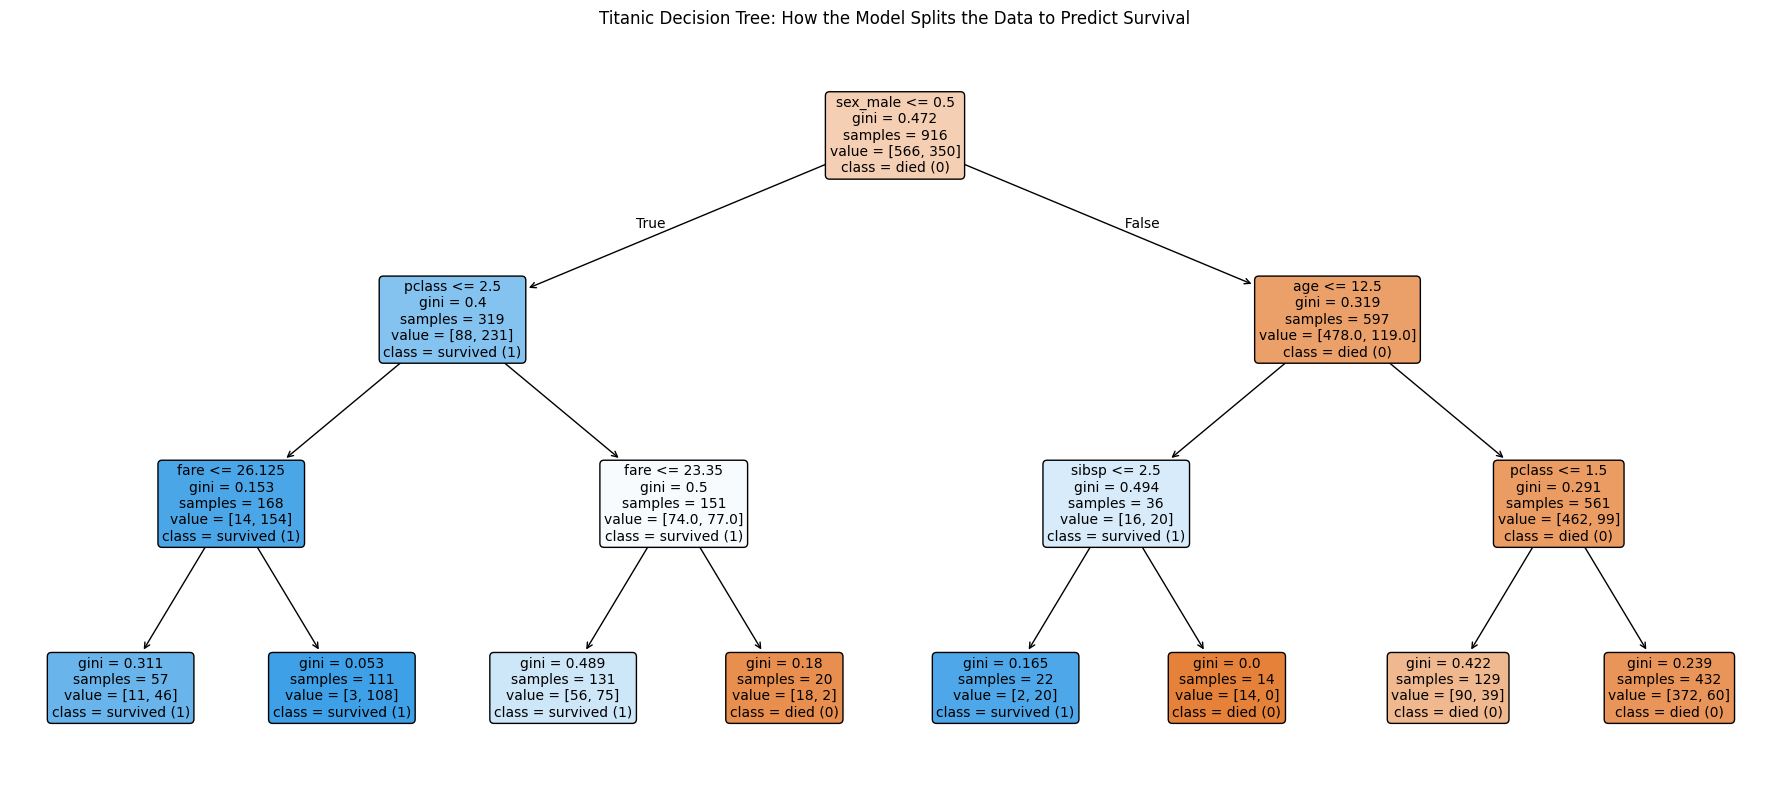

In [14]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

plt.figure(figsize=(18, 8))
plot_tree(
    tree_clf,
    feature_names=list(X.columns),
    class_names=["died (0)", "survived (1)"],
    filled=True,
    rounded=True,
    fontsize=10
)
plt.title("Titanic Decision Tree: How the Model Splits the Data to Predict Survival", pad=14)
plt.tight_layout()
plt.show()


## A Classic Dataset! (Iris Dataset)

To build confidence, let’s repeat the same workflow on the classic Iris flower dataset included in scikit-learn. The steps—split, train, validate, test—stay the same regardless of dataset size.
The Iris dataset is a classic multivariate dataset containing **150 iris flowers** from **three species**:

- _setosa_ (label `0`)
- _versicolor_ (label `1`)
- _virginica_ (label `2`)

Each row corresponds to a **single flower** and includes **four numeric features** (all in centimeters):

- `sepal length (cm)`
- `sepal width (cm)`
- `petal length (cm)`
- `petal width (cm)`

In scikit-learn, the dataset is provided as a `Bunch` object with:

- `data`: a `(150, 4)` feature matrix (`X_iris`)
- `target`: a length‑150 vector of integer labels (`y_iris`)
- `feature_names`: list of the four feature names
- `target_names`: array mapping `0, 1, 2` → `"setosa"`, `"versicolor"`, `"virginica"`

In this notebook, we:

- Built a **scatter-matrix** (`fig`) to visualize how the three species separate across pairs of features.
- Split the data into **train**, **validation**, and **test** sets (`X_train_i`, `X_val_i`, `X_test_i`, etc.).
- Trained a **DecisionTreeClassifier** (`iris_tree`) and evaluated it with accuracy on each split.
- Computed a **confusion matrix** (`iris_cm`) to see how well the model distinguishes the three species; the current tree achieves **near-perfect (in our run, perfect) accuracy** on the test set.

Because it is small, clean, and well-behaved (no missing values, balanced classes, simple numeric features), the Iris dataset is ideal for practicing supervised learning workflows: **split → train → validate → test**, interpreting decision trees, and comparing different classifiers.


![Iris Flowers Feature illustration](../../files/iris-flowers.png)


### ✏️ Exercise: Explore Feature Relationships in the Iris Dataset

#### **Prompt:**

Create an interactive visualization to explore relationships between features in the Iris dataset. Load the Iris dataset using scikit-learn and assume access to both the feature data `X_iris` and target labels `y_iris`. Construct a pandas DataFrame that includes the feature values and a human-readable species label mapped from the target indices. Use Plotly Express to generate a scatter matrix showing pairwise relationships between all numeric features, color-coded by species. Customize the plot with a clear title, clean axis labels (removing units such as “(cm)” where appropriate), and hide the diagonal plots to reduce clutter. Ensure the visualization is interactive, readable, and suitable for instructional exploration of multivariate data.


## Data Preprocessing (and why it matters)

Before training a model, we often **preprocess** the data so the learning algorithm gets clean, consistent inputs.

Common preprocessing steps:

1. **Select features + label** (define what $X$ and $y$ are).
2. **Fix data types** (e.g., strings → numbers when appropriate).
3. **Handle missing values** (impute or drop).
4. **Encode categorical variables** (e.g., one-hot encoding).
5. **Scale/standardize numeric features** (important for many models).
6. **Split into train/validation/test** without leakage.

**Important note:** Decision trees usually _do not require_ feature scaling, but models like **logistic regression**, **SVMs**, and **k-NN** often do. Using a `Pipeline` keeps preprocessing and modeling bundled together correctly (and helps prevent leakage).


### ✏️ Exercise: Create a Min–Max Scaled Scatter Matrix for the Iris Dataset

#### **Prompt:**

Build an interactive scatter-matrix visualization of the Iris dataset after applying min–max scaling. Assume the Iris dataset has already been loaded and that `X_iris` contains the feature DataFrame and `y_iris` contains the target labels. Use `MinMaxScaler` to scale all numeric features, then convert the scaled output back into a pandas DataFrame with the original column names. Add a human-readable `species` column by mapping each target value to the corresponding name in `iris.target_names`. Clean up feature names for display by removing units in parentheses (such as “(cm)”) and formatting words to look like proper titles (e.g., “Sepal Length”, “Petal Width”). Use Plotly Express to create a scatter matrix of the scaled features, color points by species, hide the diagonal panels to reduce clutter, and apply simple layout tweaks (centered title, clear legend title, and a selection-friendly drag mode) so the visualization is clean, interactive, and suitable for teaching.


### ✏️ Exercise: Train and Evaluate a Decision Tree on Scaled Iris Features

#### **Prompt:**

Train and evaluate a small decision tree classifier called `iris_tree` on the Iris dataset using scaled features from earlier cells. Assume the Iris dataset has already been loaded, with scaled features available as `df_scaled` and labels available as `y_iris`. Perform a stratified train/validation/test split by holding out 30% of the data and then splitting that holdout evenly into validation and test sets, using a fixed `random_state` for reproducibility. Train a `DecisionTreeClassifier` with a fixed `random_state` and a limited maximum depth (such as 3), compute accuracy on the train, validation, and test splits using `accuracy_score`, and display the results in a small pandas DataFrame. Finally, print a test-set `classification_report` with human-readable class names from the Iris dataset.


### ✏️ Exercise: Visualize Iris Decision Tree Results

#### **Prompt:**

Visualize the results of a trained decision tree classifier on the Iris dataset using three complementary plots: a confusion matrix, the trained tree structure, and feature importances. Assume a fitted model named `iris_tree` already exists, along with the test split `X_test` and `y_test`. Extract the feature names from the DataFrame. First, generate test-set predictions and plot a confusion matrix using scikit-learn with class labels from `iris.target_names`, formatted as integer counts and styled with a blue color map and a clear title. Next, plot the trained decision tree using `sklearn.tree.plot_tree`, using cleaned feature names (for example, removing units like “(cm)”), and include readable class names, filled and rounded nodes, and a figure size that makes the tree easy to interpret. Finally, compute and plot the model’s feature importances as a horizontal bar chart showing the most influential features (for example, the top 10), with clear axis labels and a descriptive title. Use matplotlib for all visualizations and keep the plots clean, readable, and suitable for teaching.


### Lesson Summary: Supervised Machine Learning

In this lesson, you were introduced to the fundamental ideas behind **supervised machine learning**, where models learn a mapping from input features to known output labels using labeled examples.

A central theme throughout the lesson was **generalization**. You saw that a model’s goal is not to memorize the training data, but to perform well on **unseen data**. By using train–test splits and comparing models of varying complexity, you examined the concepts of **underfitting**, **overfitting**, and how model complexity influences performance.

Overall, this lesson emphasized that supervised machine learning is a **design process**, not just an algorithm. Effective models require thoughtful data preparation, appropriate model selection, careful evaluation, and clear interpretation of results.
